In [1]:
#import subprocess
#subprocess.run(['jupyter', 'nbconvert', '--to', 'python', 'light_NN.ipynb'])

import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier 

from __future__ import print_function
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Activation, Dropout

import copy
from scipy import stats
from scipy.stats import norm, skew

from matplotlib import pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [0]:
#colab
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#ggdrive 認証
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id = "1n3Y_0qq7gNWN54LWCVr1aSK6kZ0IzEKk"#共有リンク
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train.csv')
downloaded.GetContentFile("test.csv")


In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [2]:
#jupyter_notebook
train= pd.read_csv("../data/train.csv")
test= pd.read_csv("../data/test.csv")
train.head(3)

IOError: ignored

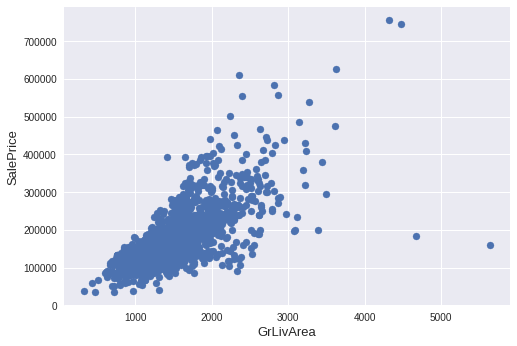

In [7]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

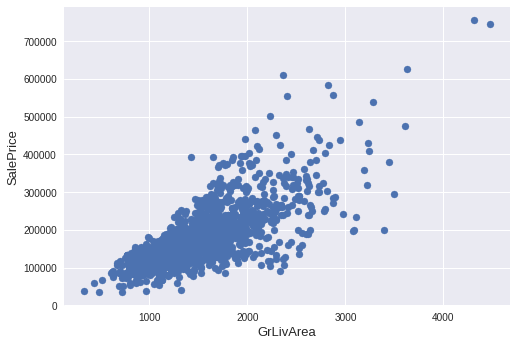

In [8]:
train = train.drop(train[(train["GrLivArea"]>4000) & (train["SalePrice"]<300000)].index)
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


 mu = 180932.92 and sigma = 79467.79



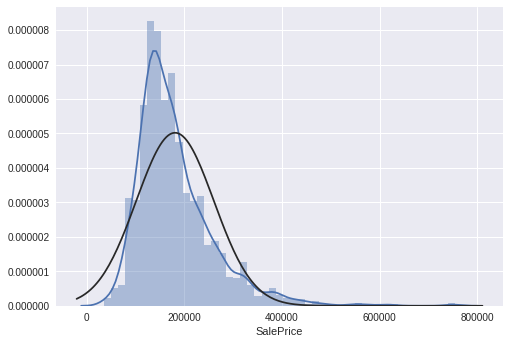

In [9]:
sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

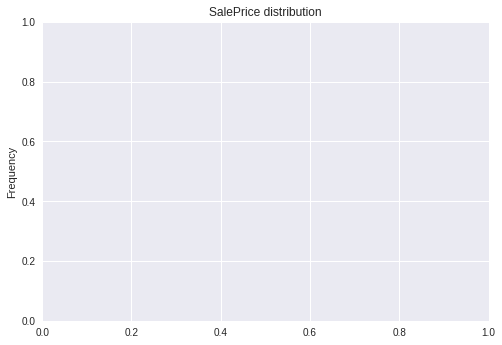

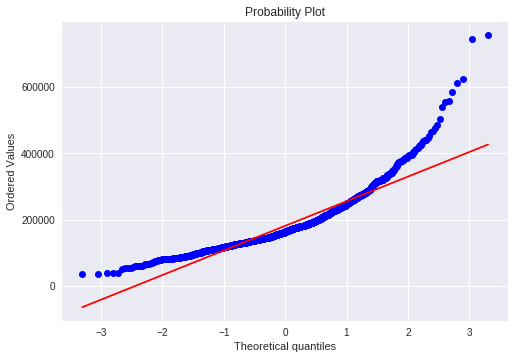

In [10]:
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')#正規分布
plt.ylabel('Frequency')#出現頻度
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)#平均からの乖離度
plt.show()


 mu = 12.02 and sigma = 0.40



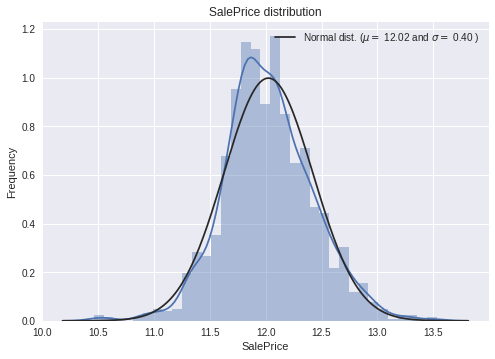

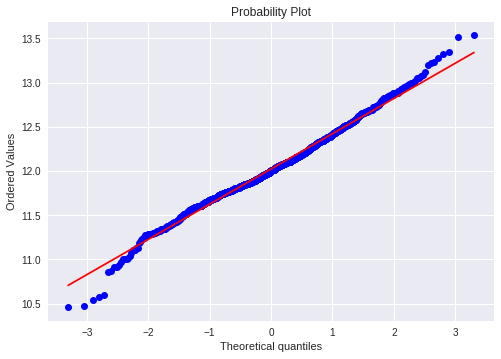

In [11]:
train["SalePrice"] = np.log(0.5+train["SalePrice"])#log(1+x)→対数変換

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);#正規分布

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)#平均乖離
plt.show()

In [12]:
ntrain = train.shape[0]#0列目要素数
ntest = test.shape[0]#0列目要素数
y_train = train.SalePrice.values#上で対数変換したpriceを取り出している
all_data = pd.concat((train, test)).reset_index(drop=True)#testとtrainを連結
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2918, 80)


In [13]:
all_data.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       518
LotArea             0
Street              0
Alley            2736
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType         16
MasVnrArea         16
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu      1380
GarageType        162
GarageYrBlt       162
GarageFinish      162
GarageCars          0
GarageArea          0
GarageQual        162
GarageCond

In [14]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100#isnull().sum()→列に含まれるnullの個数/data行数→nullの割合
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]#sort_valuesでソート順を変更
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.554489
MiscFeature,96.298835
Alley,93.762851
Fence,80.740233
FireplaceQu,47.292666
LotFrontage,17.751885
GarageYrBlt,5.551748
GarageType,5.551748
GarageFinish,5.551748
GarageQual,5.551748


/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,u'Percent missing data by feature')

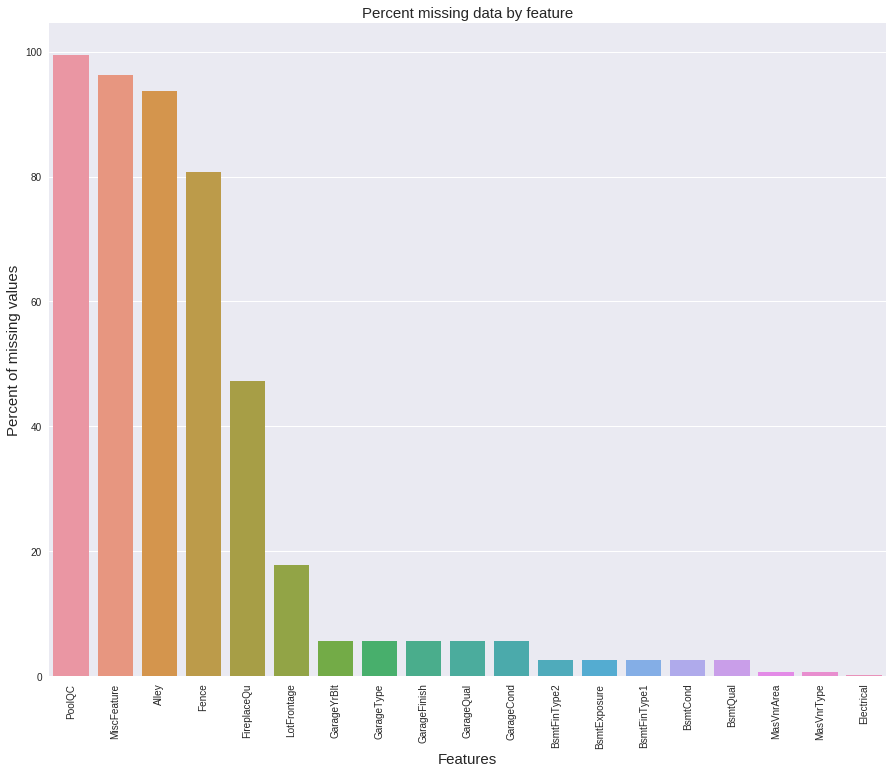

In [15]:
%matplotlib inline
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)#棒グラフ
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

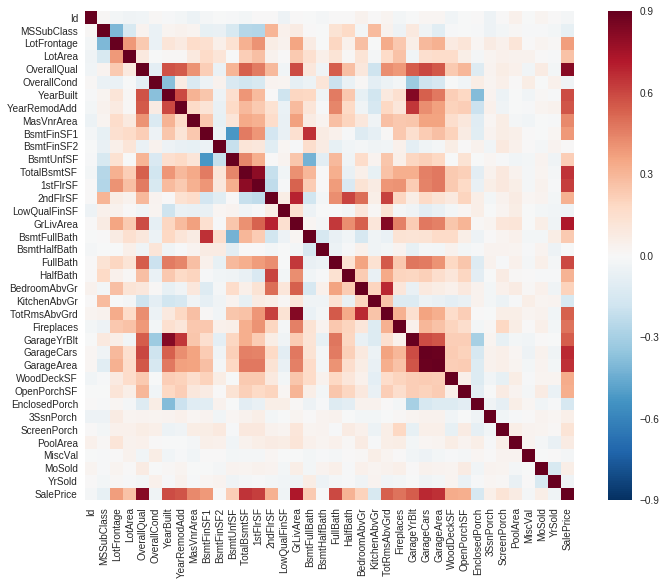

In [16]:
#priceとの相関性
corrmat = train.corr()#欠損値が除かれて相関係数が算出
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [0]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

In [0]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

In [0]:
all_data["Alley"] = all_data["Alley"].fillna("None")

In [0]:
all_data["Fence"] = all_data["Fence"].fillna("None")

In [0]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [0]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [0]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [0]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [0]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [0]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [0]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [0]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [0]:
all_data = all_data.drop(['Utilities'], axis=1)

In [0]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [0]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [0]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [0]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [0]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [0]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [36]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [0]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [38]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2918, 79)


In [0]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [40]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,24.443278
PoolArea,15.345077
LotArea,12.375218
3SsnPorch,10.290132
LowQualFinSF,8.998885
LandSlope,4.806884
KitchenAbvGr,4.482026
BsmtFinSF2,4.249219
ScreenPorch,4.116334
BsmtHalfBath,4.097541


In [41]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 60 skewed numerical features to Box Cox transform


In [42]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2918, 222)


In [0]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## modelling

In [0]:
!pip3 install cmake
!apt-get -qq install --no-install-recommends nvidia-375
!apt-get -qq install --no-install-recommends nvidia-opencl-icd-375 nvidia-opencl-dev opencl-headers!apt-get -qq install --no-install-recommends git cmake build-essential libboost-dev libboost-system-dev libboost-filesystem-dev
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd LightGBM
!mkdir build
!cd build
!cmake ..
!make -j4
!git clone --recursive https://github.com/Microsoft/LightGBM.git
%cd LightGBM/python-package
!python3 setup.py install --gpu

In [58]:
!pip3 freeze

absl-py==0.2.2
altair==2.1.0
astor==0.6.2
beautifulsoup4==4.6.0
bleach==2.1.3
cachetools==2.1.0
certifi==2018.4.16
chardet==3.0.4
cmake==3.11.0
crcmod==1.7
cycler==0.10.0
decorator==4.3.0
entrypoints==0.2.3
future==0.16.0
gast==0.2.0
google-api-core==1.2.1
google-api-python-client==1.6.7
google-auth==1.4.2
google-auth-httplib2==0.0.3
google-auth-oauthlib==0.2.0
google-cloud-bigquery==1.1.0
google-cloud-core==0.28.1
google-cloud-language==1.0.2
google-cloud-storage==1.8.0
google-cloud-translate==1.3.1
google-colab==0.0.1a1
google-resumable-media==0.3.1
googleapis-common-protos==1.5.3
grpcio==1.12.1
h5py==2.8.0
html5lib==1.0.1
httplib2==0.11.3
idna==2.6
ipykernel==4.6.1
ipython==5.5.0
ipython-genutils==0.2.0
Jinja2==2.10
jsonschema==2.6.0
jupyter-client==5.2.3
jupyter-core==4.4.0
Keras==2.1.6
lightgbm==2.1.2
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.1.2
mistune==0.8.3
mpmath==1.0.0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nltk==3.2.5
notebook==5.2.2
numpy==1.14.5
oauth2client=

In [60]:
!ls
!pip3 install wheel
!pip3 install lightgbm
!pip3 install --no-binary :all: lightgbm
!pip3 install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

build_cpp  compile  LICENSE  lightgbm  MANIFEST.in  README.rst	setup.py
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:199: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)


In [61]:

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

Exception: ignored

In [0]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [0]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [0]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [0]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [0]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [0]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [0]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [0]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [0]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [0]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1163 (0.0065)



In [0]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1161 (0.0087)



In [0]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Xgboost score: 0.1168 (0.0075)



In [0]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1142 (0.0072)



### 主成分分析(PCA)

In [0]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA



In [0]:
#train = pd.read_csv("../data/train.csv").replace("A",0).replace("RH", 1).replace("RL", 2).replace("C (all)", 3).replace("C", 3).replace("FV", 4).replace("I", 5).replace("RP", 6).replace("RM", 7).replace("Reg",0).replace("IR1", 1).replace("IR2", 2).replace("IR3", 3).replace("Pave", 0).replace("Grvl", 1).replace("Lvl", 0).replace("Bnk", 1).replace("HLS", 2).replace("Low", 3).replace("AllPub", 0).replace("Normal", 0).replace("Abnorml", 1).replace("WD", 0).replace("Gtl",0).replace("Mod", 1).replace("CulDSac", 3).replace("Corner", 2).replace("FR2", 1).replace("Inside", 0)
#test = pd.read_csv("../data/test.csv").replace("A",0).replace("RH", 1).replace("RL", 2).replace("C (all)", 3).replace("C", 3).replace("FV", 4).replace("I", 5).replace("RP", 6).replace("RM", 7).replace("Reg",0).replace("IR1", 1).replace("IR2", 2).replace("IR3", 3).replace("Pave", 0).replace("Grvl", 1).replace("Lvl", 0).replace("HLS", 1).replace("AllPub", 0).replace("Normal", 0).replace("Abnorml", 1).replace("WD", 0).replace("Gtl",0).replace("Mod", 1).replace("CulDSac", 3).replace("Corner", 2).replace("FR2", 1).replace("Inside", 0)
